In [1]:
import numpy as np
import pandas as pd
import sklearn as sl
import sklearn.preprocessing as preprocessing
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv(file_path)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,video_id,cvt_per_day,weighted_categorical_position,weighted_horizontal_poition,import_id,release_year,genres,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,awards,mpaa,star_category
0,385504,307127.605608,1,3,lionsgate,2013,"Action,Thriller,Drama",69614,15000000,42930462,6.5,112.301017,51,other award,PG-13,1.710000
1,300175,270338.426375,1,3,lionsgate,2013,"Comedy,Crime,Thriller",46705,15000000,3301046,6.5,94.983250,41,no award,R,3.250000
2,361899,256165.867446,1,3,other,2012,"Crime,Drama",197596,26000000,37397291,7.3,115.763675,58,other award,R,2.646667
3,308314,196622.720996,3,4,lionsgate,2008,"Thriller,Drama,War,Documentary,Mystery,Action",356339,15000000,15700000,7.6,130.703583,94,Oscar,R,1.666667
4,307201,159841.652064,1,3,lionsgate,2013,"Crime,Thriller,Mystery,Documentary",46720,27220000,8551228,6.4,105.545533,37,other award,R,3.066667


## EDA ##

In [2]:
if df['video_id'].duplicated().sum()==0:
  print('no duplicated index')

no duplicated index


In [3]:
df.info()
print(df.drop(columns=['video_id','release_year'],axis=1).describe(percentiles=[0.1,0.25,0.5,0.75,0.95]))
(df==0).sum(axis=0)/df.shape[0]
df.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4226 entries, 0 to 4225
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   video_id                       4226 non-null   int64  
 1   cvt_per_day                    4226 non-null   float64
 2   weighted_categorical_position  4226 non-null   int64  
 3   weighted_horizontal_poition    4226 non-null   int64  
 4   import_id                      4226 non-null   object 
 5   release_year                   4226 non-null   int64  
 6   genres                         4226 non-null   object 
 7   imdb_votes                     4226 non-null   int64  
 8   budget                         4226 non-null   int64  
 9   boxoffice                      4226 non-null   int64  
 10  imdb_rating                    4226 non-null   float64
 11  duration_in_mins               4226 non-null   float64
 12  metacritic_score               4226 non-null   i

,0
video_id,4226
cvt_per_day,4226
weighted_categorical_position,37
weighted_horizontal_poition,68
import_id,4
release_year,97
genres,1165
imdb_votes,2282
budget,253
boxoffice,410


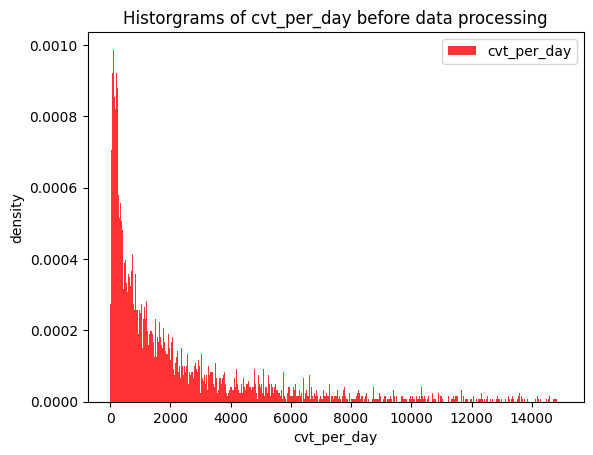

In [4]:
plt.hist(df['cvt_per_day'],bins=range(0,15000,30),color='r',label='cvt_per_day',density=True,alpha=0.8)
plt.title('Historgrams of cvt_per_day before data processing')
plt.legend(loc='upper right')
plt.xlabel('cvt_per_day')
plt.ylabel('density')
plt.show()

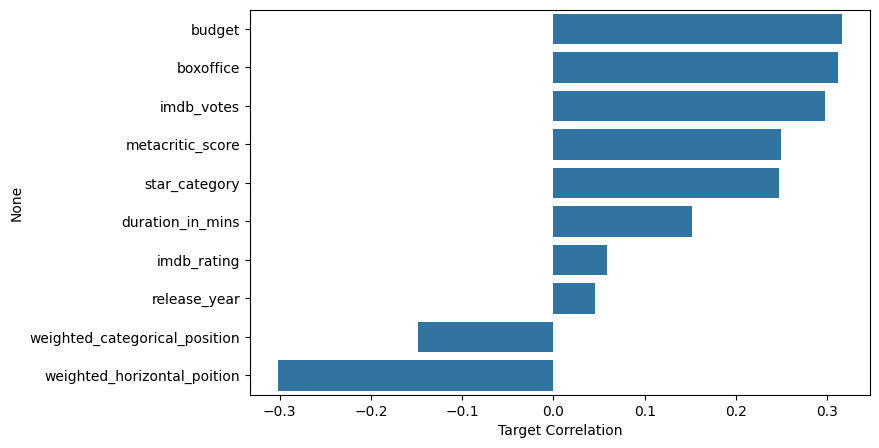

In [5]:
corr = df[['cvt_per_day','weighted_categorical_position','weighted_horizontal_poition'
               ,'release_year', 'imdb_votes', 'budget', 'boxoffice' ,'imdb_rating',
               'duration_in_mins', 'metacritic_score', 'star_category']].corr()
target_corr = corr['cvt_per_day'].drop('cvt_per_day').sort_values(ascending=False).to_frame()
target_corr.columns = ['Target Correlation']

g0 = sns.barplot(x="Target Correlation", y=target_corr.index, data=target_corr)
g0.figure.set_size_inches(8, 5)

plt.show()

## Feature Preprocessing ##

Action                    739
Adult                       3
Adventure                 363
Animation                 129
Anime                      11
Comedy                   1184
Crime                     437
Documentary               671
Drama                    1677
Fantasy                   243
Foreign/International      64
Holiday                     1
Horror                    762
Independent               393
Kids & Family             280
LGBT                        2
Lifestyle                   7
Music                     171
Musicals                   68
Mystery                   375
Reality                     9
Romance                   591
Sci-Fi                    363
Sport                      77
Thriller                  879
War                       102
Western                   102
dtype: int64


<Axes: >

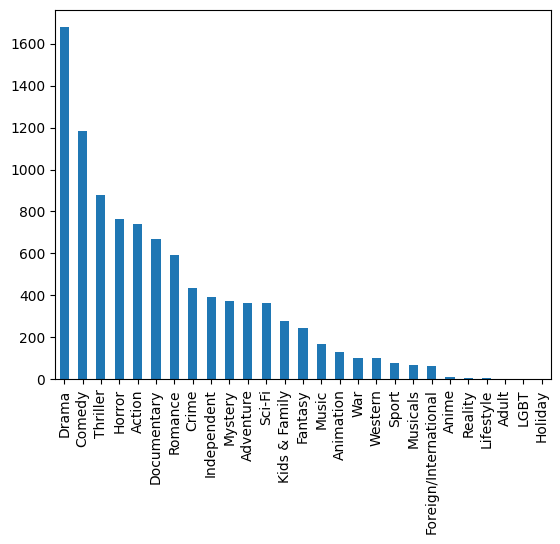

In [6]:
gen_split = df['genres'].str.get_dummies(sep=',').sum()
print(gen_split)

gen_split.sort_values(ascending=False).plot.bar()

In [7]:
d_genres=df['genres'].str.get_dummies(sep=',').astype(np.int64)
d_genres['Misc_genres']=d_genres['Anime']|d_genres['Reality']|d_genres['Lifestyle']|d_genres['Adult']|d_genres['LGBT']|d_genres['Holiday']
d_genres.drop(['Anime', 'Reality','Lifestyle', 'Adult','LGBT','Holiday'], inplace=True, axis=1)

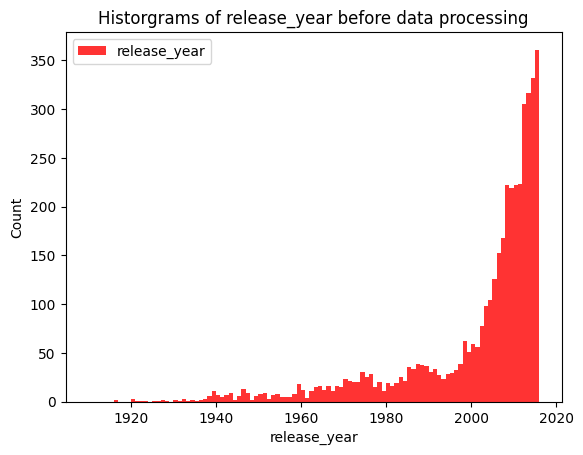

In [8]:
plt.hist(df['release_year'].values, bins = range(1910, 2017, 1), alpha = 0.8, color='r', label = 'release_year')
plt.legend(loc ='upper left')
plt.title('Historgrams of release_year before data processing')
plt.xlabel('release_year')
plt.ylabel('Count')
plt.show()

In [9]:
df['release_year'].quantile([0.25,0.5,0.75])

,release_year
0.25,1998.0
0.50,2008.0
0.75,2012.0


In [10]:
df['years'] = pd.cut(df['release_year'],
                           bins=[df['release_year'].min(), 1998, 2008, 2012, 2020],
                           labels=['Before 1998', '1998-2008', '2008-2012', '2012-2020'],
                           right=False)
d_year = pd.get_dummies(df['years']).astype(np.int64)
d_import_id = pd.get_dummies(df['import_id']).astype(np.int64)


In [11]:
def categorize_metacritic(score):
    if score >= 75:
        return 'green'
    elif score >= 50:
        return 'yellow'
    else:
        return 'red'

df['metacritic_category'] = df['metacritic_score'].apply(categorize_metacritic)
d_metacritic_category = pd.get_dummies(df['metacritic_category']).astype(np.int64)
d_import_id = pd.get_dummies(df['import_id']).astype(np.int64)
d_mpaa = pd.get_dummies(df['mpaa']).astype(np.int64)
d_awards = pd.get_dummies(df['awards']).astype(np.int64)

In [12]:
df1 = df.copy()
df1=df.drop(['import_id', 'mpaa','awards','genres', 'release_year', 'metacritic_score', 'metacritic_category', 'years'], axis=1)

df2 = pd.concat([df1, d_import_id, d_mpaa, d_awards, d_genres, d_year, d_metacritic_category], axis=1)
print(df2.head())

   video_id    cvt_per_day  weighted_categorical_position  \
0    385504  307127.605608                              1   
1    300175  270338.426375                              1   
2    361899  256165.867446                              1   
3    308314  196622.720996                              3   
4    307201  159841.652064                              1   

   weighted_horizontal_poition  imdb_votes    budget  boxoffice  imdb_rating  \
0                            3       69614  15000000   42930462          6.5   
1                            3       46705  15000000    3301046          6.5   
2                            3      197596  26000000   37397291          7.3   
3                            4      356339  15000000   15700000          7.6   
4                            3       46720  27220000    8551228          6.4   

   duration_in_mins  star_category  ...  War  Western  Misc_genres  \
0        112.301017       1.710000  ...    0        0            0   
1         94

In [13]:
df2[['budget','boxoffice']] = df2[['budget','boxoffice']].replace(0, np.nan)
print(df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4226 entries, 0 to 4225
Data columns (total 54 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   video_id                       4226 non-null   int64  
 1   cvt_per_day                    4226 non-null   float64
 2   weighted_categorical_position  4226 non-null   int64  
 3   weighted_horizontal_poition    4226 non-null   int64  
 4   imdb_votes                     4226 non-null   int64  
 5   budget                         1772 non-null   float64
 6   boxoffice                      1032 non-null   float64
 7   imdb_rating                    4226 non-null   float64
 8   duration_in_mins               4226 non-null   float64
 9   star_category                  4226 non-null   float64
 10  lionsgate                      4226 non-null   int64  
 11  mgm                            4226 non-null   int64  
 12  other                          4226 non-null   i

In [14]:
df3=df2.copy()
df3['boxoffice']=df3['boxoffice'].fillna(df3['boxoffice'].mean())
df3['budget']=df3['budget'].fillna(df3['budget'].mean())
print(df3.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4226 entries, 0 to 4225
Data columns (total 54 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   video_id                       4226 non-null   int64  
 1   cvt_per_day                    4226 non-null   float64
 2   weighted_categorical_position  4226 non-null   int64  
 3   weighted_horizontal_poition    4226 non-null   int64  
 4   imdb_votes                     4226 non-null   int64  
 5   budget                         4226 non-null   float64
 6   boxoffice                      4226 non-null   float64
 7   imdb_rating                    4226 non-null   float64
 8   duration_in_mins               4226 non-null   float64
 9   star_category                  4226 non-null   float64
 10  lionsgate                      4226 non-null   int64  
 11  mgm                            4226 non-null   int64  
 12  other                          4226 non-null   i

## Feature Scaling ##

In [15]:
scale_lst = ['weighted_categorical_position', 'weighted_horizontal_poition', 'budget','boxoffice',
             'imdb_votes','imdb_rating','duration_in_mins','star_category']
newTV_sc = df3.copy() #optional code
sc_scale = preprocessing.StandardScaler().fit(newTV_sc[scale_lst])
newTV_sc[scale_lst] = sc_scale.transform(newTV_sc[scale_lst])
newTV_sc.head()

,video_id,cvt_per_day,weighted_categorical_position,weighted_horizontal_poition,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,star_category,...,War,Western,Misc_genres,Before 1998,1998-2008,2008-2012,2012-2020,green,red,yellow
0,385504,307127.605608,-1.105826,-2.116264,1.998941,1.470049,4.695913,0.585567,1.078791,0.790998,...,0,0,0,0,0,0,1,0,0,1
1,300175,270338.426375,-1.105826,-2.116264,1.273795,1.470049,-1.022340,0.585567,0.257409,2.403677,...,0,0,0,0,0,0,1,0,1,0
2,361899,256165.867446,-1.105826,-2.116264,6.049995,3.108277,3.897514,0.962471,1.243025,1.771870,...,0,0,0,0,0,0,1,0,0,1
3,308314,196622.720996,-0.779746,-2.031963,11.074737,1.470049,0.766744,1.103810,1.951625,0.745619,...,1,0,0,0,0,1,0,1,0,0
4,307201,159841.652064,-1.105826,-2.116264,1.274270,3.289972,-0.264775,0.538454,0.758378,2.211692,...,0,0,0,0,0,0,1,0,1,0


In [16]:
train, test = train_test_split(newTV_sc, test_size=0.15, random_state = 3)
model_train_x = train.drop(['video_id', 'cvt_per_day'], axis = 1)
model_test_x = test.drop(['video_id', 'cvt_per_day'], axis = 1)
model_train_y = train['cvt_per_day']
model_test_y = test['cvt_per_day']

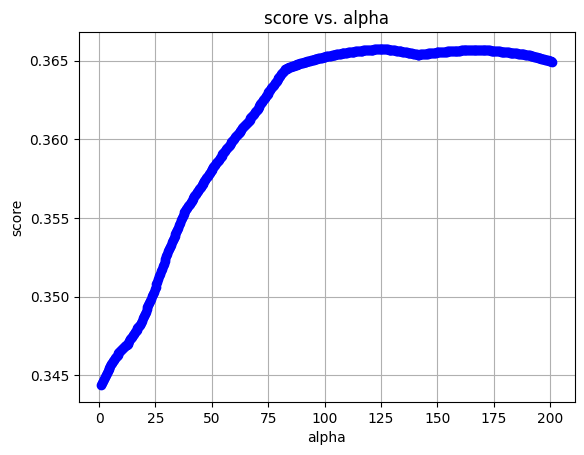

The optimaized alpha and score of Lasso linear is: 


(None, 126.45090180360722, 0.365739246693609)

In [18]:
#Lasso
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score #not used
from math import sqrt

lr_train, lr_validate = train_test_split(train, test_size=0.15, random_state = 0)

lr_train_x = lr_train.drop(['video_id', 'cvt_per_day'], axis = 1)
lr_validate_x = lr_validate.drop(['video_id', 'cvt_per_day'], axis = 1)
lr_train_y = lr_train['cvt_per_day']
lr_validate_y = lr_validate['cvt_per_day']

alphas = np.linspace (1, 201, num=500)
scores = np.empty_like(alphas)
opt_a = float('-inf')
max_score = float('-inf')
for i, a in enumerate(alphas):
    lasso = Lasso()
    lasso.set_params(alpha = a)
    lasso.fit(lr_train_x, lr_train_y)
    scores[i] = lasso.score(lr_validate_x, lr_validate_y)
    if scores[i] > max_score:
        max_score = scores[i]
        opt_a = a
        lasso_save = lasso

plt.plot(alphas, scores, color='b', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=6)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
model1_para = opt_a
print ('The optimaized alpha and score of Lasso linear is: '), opt_a, max_score


In [19]:
lasso_f = Lasso()
lasso_f.set_params(alpha = opt_a)
lasso_f.fit(model_train_x, model_train_y)


Lasso(alpha=126.45090180360722)

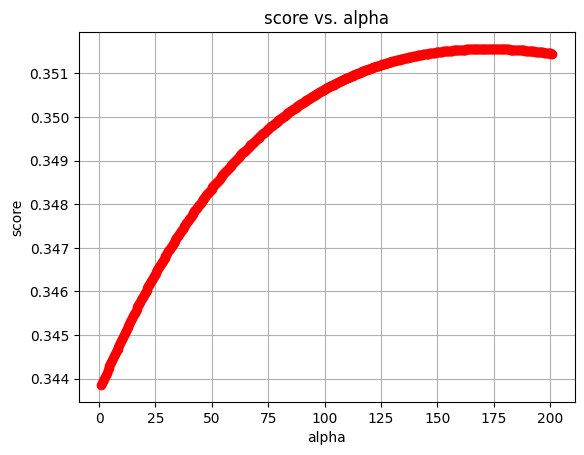

The optimaized alpha and score of Ridge linear is: 


(None, 172.14228456913827, 0.3515612239219561)

In [20]:
#Ridge
lr_train, lr_validate = train_test_split(train, test_size=0.15, random_state = 0)

alphas = np.linspace (1, 201, num=500)
scores = np.empty_like(alphas)
opt_a = float('-inf')
max_score = float('-inf')
for i, a in enumerate(alphas):
    ridge = Ridge()
    ridge.set_params(alpha = a)
    ridge.fit(lr_train_x, lr_train_y)
    scores[i] = ridge.score(lr_validate_x, lr_validate_y)
    if scores[i] > max_score:
        max_score = scores[i]
        opt_a = a
        ridge_save = ridge
plt.plot(alphas, scores, color='r', linestyle='dashed', marker='o',markerfacecolor='r', markersize=6)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
model3_para = opt_a
print ('The optimaized alpha and score of Ridge linear is: '), opt_a, max_score

In [21]:
ridge_f = Ridge()
ridge_f.set_params(alpha = opt_a)
ridge_f.fit(model_train_x, model_train_y)

Ridge(alpha=172.14228456913827)

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
rf=RandomForestRegressor(random_state=2,max_features='sqrt')
param_grid={'n_estimators':[55,56,57,58,59,60,61,62,63,64,65],'max_depth':[15,16,17,18,19,20,21]}
clf=GridSearchCV(estimator=rf,param_grid=param_grid,cv=5)
clf.fit(model_train_x,model_train_y)

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_features='sqrt',
                                             random_state=2),
             param_grid={'max_depth': [15, 16, 17, 18, 19, 20, 21],
                         'n_estimators': [55, 56, 57, 58, 59, 60, 61, 62, 63,
                                          64, 65]})

{'mean_fit_time': array([0.62110496, 0.37557173, 0.48817101, 0.49155283, 0.34878426,
       0.34679618, 0.3552392 , 0.36851025, 0.60447645, 0.98725743,
       0.60643029, 0.6098206 , 0.55689278, 0.99194655, 0.84934835,
       0.61017299, 0.56397858, 1.42974954, 0.85195193, 0.61294951,
       0.94243355, 0.50606489, 0.37965984, 0.6340405 , 0.74807944,
       1.21098657, 0.4715795 , 0.51121159, 0.59301214, 0.83115568,
       0.75798345, 0.65631223, 0.70008063, 0.98741612, 0.83043914,
       0.44141154, 0.38711853, 0.51750646, 1.10072184, 0.61878185,
       0.59816513, 0.84071665, 0.90637827, 0.71187038, 0.38297563,
       0.39250393, 0.45294385, 0.61087127, 0.43930883, 0.41847668,
       0.42288294, 0.43075881, 1.02453055, 0.90972137, 0.58057499,
       0.86558084, 1.23573155, 0.58627172, 0.61958356, 0.43246861,
       0.64228544, 0.51078272, 0.44399791, 0.44525666, 0.46091323,
       0.57098665, 0.59782968, 0.40866756, 0.5295012 , 0.51568532,
       0.52555408, 1.23757715, 0.74954138, 0

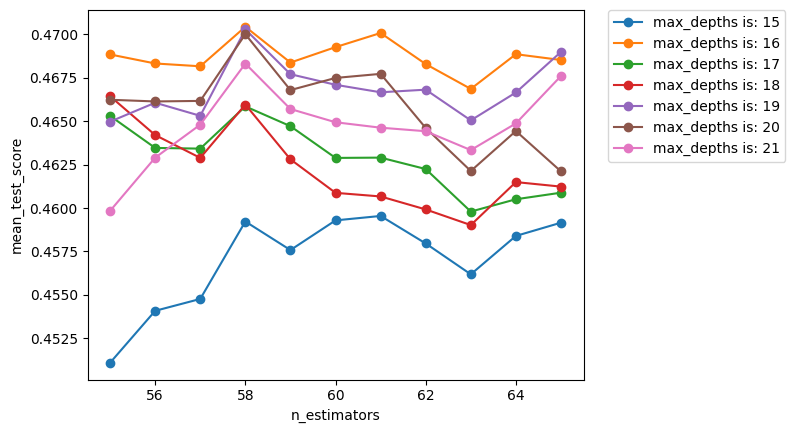

the best parameter for max_depth is: 16
the best parameter for n_estimators is: 58


In [23]:
result=clf.cv_results_
print(result)
max_depth=[15,16,17,18,19,20,21]
n_estimators=[55,56,57,58,59,60,61,62,63,64,65]
scores=clf.cv_results_['mean_test_score'].reshape(len(max_depth),len(n_estimators))
plt.figure(1)
plt.subplot(1,1,1)
for i,j in enumerate(max_depth):
  plt.plot(n_estimators,scores[i],'-o',label='max_depths is: '+str(j))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('n_estimators')
plt.ylabel('mean_test_score')
plt.show()
print('the best parameter for max_depth is: '+str(clf.best_params_['max_depth']))
print('the best parameter for n_estimators is: '+str(clf.best_params_['n_estimators']))



## Evaluate all models ##

In [24]:
train_x = model_train_x
train_y = model_train_y
test_x = model_test_x
test_y = model_test_y

In [25]:
from sklearn.linear_model import Lasso
from sklearn.metrics import  mean_squared_error
lasso=Lasso(alpha=model1_para)
lasso.fit(train_x,train_y)
pred_y=lasso.predict(test_x)
lasso_score=lasso.score(test_x,test_y)
MSE_lasso=mean_squared_error(test_y,pred_y)
RMSE_lasso=np.sqrt(MSE_lasso)
print ('lasso score: ', lasso_score)
print ('Mean square error of lasso: ', MSE_lasso)
print ('Root mean squared error of lasso:', RMSE_lasso)

lasso score:  0.09795718914762308
Mean square error of lasso:  239375683.99873367
Root mean squared error of lasso: 15471.770551515223


In [26]:
from sklearn.metrics import  mean_squared_error
ridge=Ridge(alpha=model3_para)
ridge.fit(train_x,train_y)
pred_y=ridge.predict(test_x)
ridge_score=ridge.score(test_x,test_y)
MSE_ridge=mean_squared_error(test_y,pred_y)
RMSE_ridge=np.sqrt(MSE_ridge)
print ('ridge score: ', ridge_score)
print ('Mean square error of ridge: ', MSE_ridge)
print ('Root mean squared error of ridge:', RMSE_ridge)

ridge score:  0.1126891509159681
Mean square error of ridge:  235466253.7782229
Root mean squared error of ridge: 15344.909702511217


In [27]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(n_estimators=clf.best_params_['n_estimators'],max_depth=clf.best_params_['max_depth'],max_features='sqrt',random_state=2,n_jobs=-1)
rf.fit(train_x,train_y)
pred_y=rf.predict(test_x)
rf_score=rf.score(test_x,test_y)
MSE_rf=mean_squared_error(test_y,pred_y)
RMSE_rf=np.sqrt(MSE_rf)
print ('rf score: ', rf_score)
print ('Mean square error of rf: ', MSE_rf)
print ('Root mean squared error of rf:', RMSE_rf)

rf score:  0.5851290213628104
Mean square error of rf:  110094579.86662427
Root mean squared error of rf: 10492.596431132966


**According to MSE,RMSE and R square, the Random Forest Regression has the best performance**

## Feature Importance ##

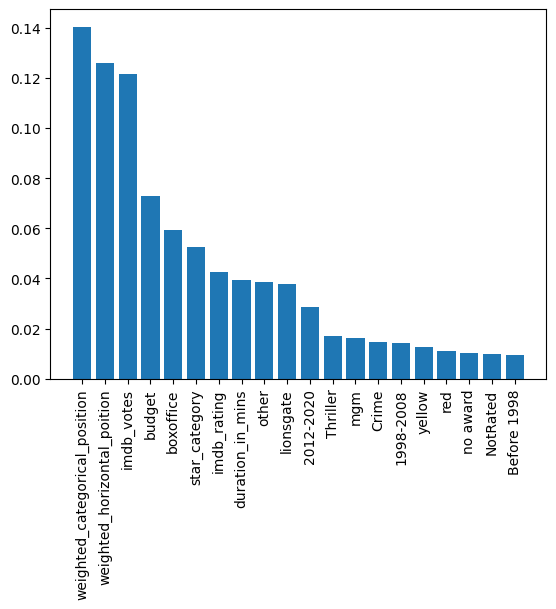

In [28]:
importances = rf.feature_importances_
feature_name = train_x.columns.values
indices = np.argsort(importances)[::-1]
plt.figure(1)
plt.bar(feature_name[indices[:20]], importances[indices[:20]])
plt.xticks(rotation=90)
plt.show()